# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.Session(config=config)

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
# ROOT_DIR = '/content/drive/My Drive/Mask_RCNN'
ROOT_DIR = 'C:\\Users\\iFai1\\Desktop\\Cornell\\MRCNN_Iteration\\Mask_RCNN\\'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        # Figure out how many classes there are in the picture
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        print('our info is: ', info)
        print('our shapes is: ', shapes)
        print('our count is: ', count)
        
        # We then create a mask, which consists of the number of shapes for that image that are PRESENT.
        # These are blank at first.
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
#         print('our mask is: ', mask)
        print('initial mask shape: ', mask.shape)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        print('our class ids: ')
        print(class_ids)
        print(class_ids.shape)
        print('mask')
        print(mask.shape)
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [7]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

our info is:  {'id': 182, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([222,  43, 124]), 'shapes': [('triangle', (36, 133, 16), (64, 53, 24)), ('square', (42, 230, 141), (41, 79, 24)), ('circle', (81, 117, 199), (98, 75, 29))]}
our shapes is:  [('triangle', (36, 133, 16), (64, 53, 24)), ('square', (42, 230, 141), (41, 79, 24)), ('circle', (81, 117, 199), (98, 75, 29))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[3 1 2]
(3,)
mask
(128, 128, 3)


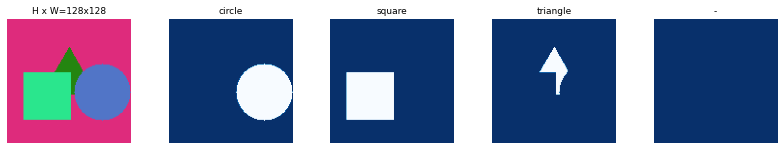

our info is:  {'id': 181, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([252, 105,  45]), 'shapes': [('triangle', (156, 237, 66), (59, 89, 30)), ('triangle', (203, 222, 134), (76, 72, 23))]}
our shapes is:  [('triangle', (156, 237, 66), (59, 89, 30)), ('triangle', (203, 222, 134), (76, 72, 23))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[3 3]
(2,)
mask
(128, 128, 2)


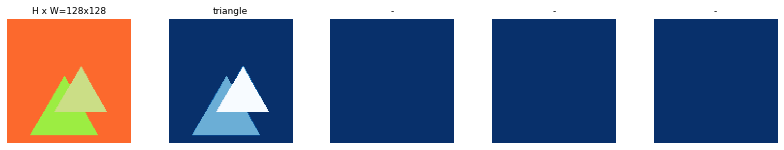

our info is:  {'id': 25, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([159, 104, 161]), 'shapes': [('circle', (43, 43, 233), (106, 62, 25)), ('triangle', (137, 2, 111), (21, 80, 23)), ('triangle', (252, 17, 13), (106, 26, 32)), ('triangle', (223, 151, 139), (74, 72, 29))]}
our shapes is:  [('circle', (43, 43, 233), (106, 62, 25)), ('triangle', (137, 2, 111), (21, 80, 23)), ('triangle', (252, 17, 13), (106, 26, 32)), ('triangle', (223, 151, 139), (74, 72, 29))]
our count is:  4
initial mask shape:  (128, 128, 4)
our class ids: 
[2 3 3 3]
(4,)
mask
(128, 128, 4)


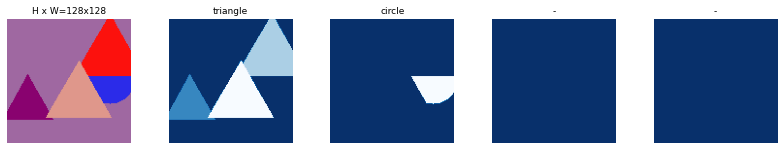

our info is:  {'id': 9, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([190,  82,  89]), 'shapes': [('circle', (69, 70, 74), (71, 106, 24)), ('square', (146, 147, 253), (66, 69, 23))]}
our shapes is:  [('circle', (69, 70, 74), (71, 106, 24)), ('square', (146, 147, 253), (66, 69, 23))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 1]
(2,)
mask
(128, 128, 2)


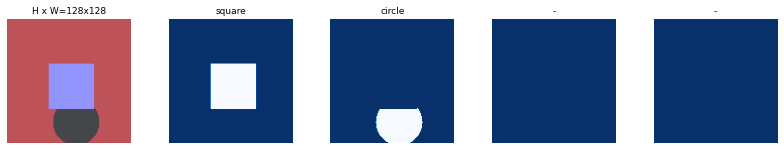

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\logs\shapes20200531T0732\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4

c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/1
WE GOT TO HERE
OUR IMAGE ID IS:  362
our info is:  {'id': 362, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([211, 119, 147]), 'shapes': [('square', (157, 62, 188), (58, 50, 23))]}
our shapes is:  [('square', (157, 62, 188), (58, 50, 23))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  455
our info is:  {'id': 455, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([122, 246,  18]), 'shapes': [('circle', (229, 133, 200), (82, 82, 20)), ('triangle', (216, 33, 17), (54, 95, 25)), ('square', (162, 222, 75), (40, 46, 32)), ('circle', (11, 117, 122), (84, 33, 24))]}
our shapes is:  [('circle', (229, 133, 200), (82, 82, 20)), ('triangle', (216, 33, 17), (54, 95, 25)), ('square', (162, 222, 75), (40, 46, 32)), ('circle', (11, 117, 122), (84, 33, 24))]
our count is:  4
initial mask shape:  (128, 128, 4)
our class ids: 
[2 3 1 2]
(4,)
m

  2/100 [..............................] - ETA: 12:59 - loss: 5.7700 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 2.2277 - mrcnn_class_loss: 0.7458 - mrcnn_bbox_loss: 1.2096 - mrcnn_mask_loss: 1.4985WE GOT TO HERE
OUR IMAGE ID IS:  492
our info is:  {'id': 492, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([  5,  82, 130]), 'shapes': [('circle', (49, 39, 94), (54, 54, 27)), ('circle', (54, 99, 5), (25, 54, 26))]}
our shapes is:  [('circle', (49, 39, 94), (54, 54, 27)), ('circle', (54, 99, 5), (25, 54, 26))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  411
our info is:  {'id': 411, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([210, 134,  15]), 'shapes': [('square', (125, 117, 101), (32, 98, 32)), ('triangle', (204, 199, 241), (48, 63, 27))]}
our shapes is:  [('square', (125, 117, 101), (32, 98, 32)), ('triangle', (204, 199, 241), (48, 

  5/100 [>.............................] - ETA: 5:23 - loss: 4.9481 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.9621 - mrcnn_class_loss: 0.7010 - mrcnn_bbox_loss: 0.9880 - mrcnn_mask_loss: 1.2107WE GOT TO HERE
OUR IMAGE ID IS:  185
our info is:  {'id': 185, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 75, 193, 147]), 'shapes': [('triangle', (185, 54, 210), (95, 41, 27)), ('triangle', (100, 106, 44), (93, 78, 25))]}
our shapes is:  [('triangle', (185, 54, 210), (95, 41, 27)), ('triangle', (100, 106, 44), (93, 78, 25))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[3 3]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  210
our info is:  {'id': 210, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 60, 194,   9]), 'shapes': [('square', (129, 182, 43), (53, 86, 26)), ('square', (4, 119, 93), (70, 56, 30))]}
our shapes is:  [('square', (129, 182, 43), (53, 86, 26)), ('square', (4, 119, 93), 

  8/100 [=>............................] - ETA: 3:27 - loss: 4.4464 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.6041 - mrcnn_class_loss: 0.7080 - mrcnn_bbox_loss: 0.9160 - mrcnn_mask_loss: 1.1325WE GOT TO HERE
OUR IMAGE ID IS:  32
our info is:  {'id': 32, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([176, 108,  97]), 'shapes': [('circle', (237, 84, 228), (62, 69, 20))]}
our shapes is:  [('circle', (237, 84, 228), (62, 69, 20))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  365
our info is:  {'id': 365, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 15, 218,  43]), 'shapes': [('square', (3, 22, 65), (70, 58, 24)), ('square', (45, 241, 71), (35, 40, 31)), ('square', (109, 120, 50), (48, 95, 21))]}
our shapes is:  [('square', (3, 22, 65), (70, 58, 24)), ('square', (45, 241, 71), (35, 40, 31)), ('square', (109, 120, 50), (48, 95, 21))]
o

 11/100 [==>...........................] - ETA: 2:35 - loss: 4.0498 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 1.4258 - mrcnn_class_loss: 0.6600 - mrcnn_bbox_loss: 0.8672 - mrcnn_mask_loss: 1.0154WE GOT TO HERE
OUR IMAGE ID IS:  239
our info is:  {'id': 239, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([140, 207,   5]), 'shapes': [('triangle', (250, 103, 167), (102, 67, 25)), ('triangle', (55, 22, 30), (39, 76, 31)), ('circle', (62, 176, 16), (64, 50, 24))]}
our shapes is:  [('triangle', (250, 103, 167), (102, 67, 25)), ('triangle', (55, 22, 30), (39, 76, 31)), ('circle', (62, 176, 16), (64, 50, 24))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[3 3 2]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  70
our info is:  {'id': 70, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 92, 191, 123]), 'shapes': [('circle', (1, 214, 236), (102, 24, 27)), ('triangle', (27, 180, 141), (54, 24, 30)),

 14/100 [===>..........................] - ETA: 2:04 - loss: 3.7627 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.2792 - mrcnn_class_loss: 0.6298 - mrcnn_bbox_loss: 0.8366 - mrcnn_mask_loss: 0.9390WE GOT TO HERE
OUR IMAGE ID IS:  233
our info is:  {'id': 233, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([216, 180,  69]), 'shapes': [('square', (186, 203, 225), (75, 44, 23))]}
our shapes is:  [('square', (186, 203, 225), (75, 44, 23))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  122
our info is:  {'id': 122, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([239, 156, 188]), 'shapes': [('square', (186, 124, 200), (31, 49, 29)), ('square', (119, 254, 61), (100, 39, 27)), ('triangle', (70, 185, 110), (61, 82, 28))]}
our shapes is:  [('square', (186, 124, 200), (31, 49, 29)), ('square', (119, 254, 61), (100, 39, 27)), ('triangle', (70, 185, 11

 19/100 [====>.........................] - ETA: 1:33 - loss: 3.3534 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 1.1116 - mrcnn_class_loss: 0.5648 - mrcnn_bbox_loss: 0.7616 - mrcnn_mask_loss: 0.8444WE GOT TO HERE
OUR IMAGE ID IS:  488
our info is:  {'id': 488, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([139,  52,  18]), 'shapes': [('square', (119, 180, 115), (63, 80, 28)), ('circle', (51, 10, 214), (104, 96, 26))]}
our shapes is:  [('square', (119, 180, 115), (63, 80, 28)), ('circle', (51, 10, 214), (104, 96, 26))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  461
our info is:  {'id': 461, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([188,  77, 165]), 'shapes': [('square', (45, 139, 156), (54, 91, 27)), ('circle', (7, 143, 211), (39, 41, 27))]}
our shapes is:  [('square', (45, 139, 156), (54, 91, 27)), ('circle', (7, 143, 211), (39,

 23/100 [=====>........................] - ETA: 1:18 - loss: 3.1396 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.0134 - mrcnn_class_loss: 0.5394 - mrcnn_bbox_loss: 0.7281 - mrcnn_mask_loss: 0.7919WE GOT TO HERE
OUR IMAGE ID IS:  121
our info is:  {'id': 121, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([216, 169, 124]), 'shapes': [('triangle', (150, 207, 75), (58, 89, 29)), ('square', (20, 157, 202), (52, 29, 32))]}
our shapes is:  [('triangle', (150, 207, 75), (58, 89, 29)), ('square', (20, 157, 202), (52, 29, 32))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[3 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  2
our info is:  {'id': 2, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([182, 130,  15]), 'shapes': [('square', (153, 89, 187), (66, 106, 26)), ('triangle', (5, 169, 174), (75, 22, 26))]}
our shapes is:  [('square', (153, 89, 187), (66, 106, 26)), ('triangle', (5, 169, 174), 

 25/100 [======>.......................] - ETA: 1:12 - loss: 3.0527 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.9812 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 0.7076 - mrcnn_mask_loss: 0.7677WE GOT TO HERE
OUR IMAGE ID IS:  24
our info is:  {'id': 24, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([120, 239, 187]), 'shapes': [('square', (164, 31, 131), (28, 81, 30)), ('square', (171, 132, 193), (80, 66, 31))]}
our shapes is:  [('square', (164, 31, 131), (28, 81, 30)), ('square', (171, 132, 193), (80, 66, 31))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  163
our info is:  {'id': 163, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 67, 205, 235]), 'shapes': [('square', (233, 169, 91), (71, 43, 22))]}
our shapes is:  [('square', (233, 169, 91), (71, 43, 22))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(

 27/100 [=======>......................] - ETA: 1:07 - loss: 2.9632 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.9441 - mrcnn_class_loss: 0.5259 - mrcnn_bbox_loss: 0.6847 - mrcnn_mask_loss: 0.7451WE GOT TO HERE
OUR IMAGE ID IS:  432
our info is:  {'id': 432, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([139,  49, 229]), 'shapes': [('circle', (141, 29, 9), (43, 52, 20)), ('circle', (11, 80, 88), (77, 84, 24))]}
our shapes is:  [('circle', (141, 29, 9), (43, 52, 20)), ('circle', (11, 80, 88), (77, 84, 24))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  338
our info is:  {'id': 338, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([167, 224, 229]), 'shapes': [('circle', (90, 88, 229), (104, 59, 29))]}
our shapes is:  [('circle', (90, 88, 229), (104, 59, 29))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask

 30/100 [========>.....................] - ETA: 1:00 - loss: 2.8348 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.9019 - mrcnn_class_loss: 0.5043 - mrcnn_bbox_loss: 0.6555 - mrcnn_mask_loss: 0.7130WE GOT TO HERE
OUR IMAGE ID IS:  166
our info is:  {'id': 166, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([  3, 198,  98]), 'shapes': [('circle', (19, 200, 44), (77, 84, 26)), ('square', (185, 47, 97), (95, 64, 28))]}
our shapes is:  [('circle', (19, 200, 44), (77, 84, 26)), ('square', (185, 47, 97), (95, 64, 28))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  458
our info is:  {'id': 458, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([248,  55,  17]), 'shapes': [('square', (135, 66, 45), (23, 49, 22)), ('circle', (47, 127, 140), (93, 55, 29))]}
our shapes is:  [('square', (135, 66, 45), (23, 49, 22)), ('circle', (47, 127, 140), (93, 55, 2

 32/100 [========>.....................] - ETA: 56s - loss: 2.7649 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.8755 - mrcnn_class_loss: 0.4969 - mrcnn_bbox_loss: 0.6382 - mrcnn_mask_loss: 0.6957WE GOT TO HERE
OUR IMAGE ID IS:  227
our info is:  {'id': 227, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 35, 206,  15]), 'shapes': [('triangle', (33, 255, 111), (81, 55, 28))]}
our shapes is:  [('triangle', (33, 255, 111), (81, 55, 28))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[3]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  78
our info is:  {'id': 78, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 10,  31, 223]), 'shapes': [('square', (168, 246, 192), (87, 107, 24)), ('square', (165, 251, 194), (48, 45, 28)), ('triangle', (171, 92, 132), (43, 103, 28)), ('circle', (71, 220, 215), (58, 71, 30))]}
our shapes is:  [('square', (168, 246, 192), (87, 107, 24)), ('square', (165, 251, 19

 35/100 [=========>....................] - ETA: 51s - loss: 2.6595 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.8456 - mrcnn_class_loss: 0.4786 - mrcnn_bbox_loss: 0.6107 - mrcnn_mask_loss: 0.6689WE GOT TO HERE
OUR IMAGE ID IS:  76
our info is:  {'id': 76, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([11, 32, 43]), 'shapes': [('triangle', (105, 44, 191), (61, 91, 29)), ('circle', (232, 86, 9), (45, 33, 20)), ('circle', (28, 237, 246), (23, 89, 21))]}
our shapes is:  [('triangle', (105, 44, 191), (61, 91, 29)), ('circle', (232, 86, 9), (45, 33, 20)), ('circle', (28, 237, 246), (23, 89, 21))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[3 2 2]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  119
our info is:  {'id': 119, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 60,  43, 209]), 'shapes': [('square', (200, 237, 247), (61, 69, 20)), ('triangle', (248, 64, 230), (82, 57, 29)), ('triang

 37/100 [==========>...................] - ETA: 48s - loss: 2.6028 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 0.8297 - mrcnn_class_loss: 0.4702 - mrcnn_bbox_loss: 0.5970 - mrcnn_mask_loss: 0.6515WE GOT TO HERE
OUR IMAGE ID IS:  451
our info is:  {'id': 451, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 13, 225, 108]), 'shapes': [('circle', (104, 32, 145), (39, 67, 23)), ('square', (136, 27, 107), (101, 70, 24))]}
our shapes is:  [('circle', (104, 32, 145), (39, 67, 23)), ('square', (136, 27, 107), (101, 70, 24))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  328
our info is:  {'id': 328, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([28, 20, 24]), 'shapes': [('square', (217, 179, 209), (79, 80, 22)), ('circle', (3, 82, 45), (106, 91, 28)), ('square', (153, 132, 216), (57, 67, 24))]}
our shapes is:  [('square', (217, 179, 209), (79, 

 40/100 [===========>..................] - ETA: 44s - loss: 2.5207 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.4614 - mrcnn_bbox_loss: 0.5750 - mrcnn_mask_loss: 0.6284WE GOT TO HERE
OUR IMAGE ID IS:  469
our info is:  {'id': 469, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([230, 119, 108]), 'shapes': [('triangle', (76, 18, 143), (88, 107, 22))]}
our shapes is:  [('triangle', (76, 18, 143), (88, 107, 22))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[3]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  343
our info is:  {'id': 343, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([  9, 163,  16]), 'shapes': [('square', (12, 60, 80), (101, 22, 30)), ('triangle', (255, 145, 139), (96, 72, 20)), ('circle', (37, 40, 169), (60, 72, 27))]}
our shapes is:  [('square', (12, 60, 80), (101, 22, 30)), ('triangle', (255, 145, 139), (96, 72, 20)), ('circle', (37, 40, 169), (

 43/100 [===========>..................] - ETA: 40s - loss: 2.4435 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.7817 - mrcnn_class_loss: 0.4528 - mrcnn_bbox_loss: 0.5549 - mrcnn_mask_loss: 0.6047WE GOT TO HERE
OUR IMAGE ID IS:  12
our info is:  {'id': 12, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([185,  16,  96]), 'shapes': [('square', (157, 29, 186), (80, 64, 22)), ('square', (195, 4, 104), (52, 79, 29))]}
our shapes is:  [('square', (157, 29, 186), (80, 64, 22)), ('square', (195, 4, 104), (52, 79, 29))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  36
our info is:  {'id': 36, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([149, 234,   1]), 'shapes': [('triangle', (113, 251, 204), (40, 49, 22)), ('triangle', (61, 48, 57), (92, 25, 29)), ('square', (167, 22, 239), (73, 54, 31)), ('circle', (243, 230, 78), (106, 87, 25))]}
our shape

 45/100 [============>.................] - ETA: 38s - loss: 2.4001 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.7695 - mrcnn_class_loss: 0.4497 - mrcnn_bbox_loss: 0.5430 - mrcnn_mask_loss: 0.5900WE GOT TO HERE
OUR IMAGE ID IS:  345
our info is:  {'id': 345, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 78,  49, 187]), 'shapes': [('circle', (205, 172, 173), (73, 94, 22)), ('triangle', (129, 85, 21), (103, 24, 21))]}
our shapes is:  [('circle', (205, 172, 173), (73, 94, 22)), ('triangle', (129, 85, 21), (103, 24, 21))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 3]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  243
our info is:  {'id': 243, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([157, 110, 200]), 'shapes': [('square', (147, 181, 146), (77, 103, 29))]}
our shapes is:  [('square', (147, 181, 146), (77, 103, 29))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class id

 48/100 [=============>................] - ETA: 35s - loss: 2.3286 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.7490 - mrcnn_class_loss: 0.4387 - mrcnn_bbox_loss: 0.5263 - mrcnn_mask_loss: 0.5684WE GOT TO HERE
OUR IMAGE ID IS:  281
our info is:  {'id': 281, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([105,  56, 191]), 'shapes': [('triangle', (27, 121, 239), (39, 27, 25)), ('circle', (87, 71, 146), (73, 26, 32))]}
our shapes is:  [('triangle', (27, 121, 239), (39, 27, 25)), ('circle', (87, 71, 146), (73, 26, 32))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[3 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  147
our info is:  {'id': 147, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([99, 93, 58]), 'shapes': [('triangle', (163, 226, 9), (38, 80, 25))]}
our shapes is:  [('triangle', (163, 226, 9), (38, 80, 25))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[3]
(

 51/100 [==============>...............] - ETA: 32s - loss: 2.2638 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.4282 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.5485WE GOT TO HERE
OUR IMAGE ID IS:  340
our info is:  {'id': 340, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([249, 246,  85]), 'shapes': [('square', (166, 157, 109), (103, 88, 26))]}
our shapes is:  [('square', (166, 157, 109), (103, 88, 26))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  117
our info is:  {'id': 117, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([  2, 248,  49]), 'shapes': [('square', (207, 165, 25), (49, 23, 28)), ('triangle', (65, 77, 202), (72, 52, 22))]}
our shapes is:  [('square', (207, 165, 25), (49, 23, 28)), ('triangle', (65, 77, 202), (72, 52, 22))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1

 54/100 [===============>..............] - ETA: 29s - loss: 2.2016 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7119 - mrcnn_class_loss: 0.4177 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.5293WE GOT TO HERE
OUR IMAGE ID IS:  437
our info is:  {'id': 437, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([167,  81, 137]), 'shapes': [('square', (32, 255, 171), (41, 53, 28))]}
our shapes is:  [('square', (32, 255, 171), (41, 53, 28))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  127
our info is:  {'id': 127, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 51, 237,  84]), 'shapes': [('circle', (163, 30, 84), (88, 33, 25)), ('square', (49, 9, 105), (99, 105, 28))]}
our shapes is:  [('circle', (163, 30, 84), (88, 33, 25)), ('square', (49, 9, 105), (99, 105, 28))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 1]
(2,)
m

 56/100 [===============>..............] - ETA: 27s - loss: 2.1660 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7041 - mrcnn_class_loss: 0.4112 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.5178WE GOT TO HERE
OUR IMAGE ID IS:  151
our info is:  {'id': 151, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([163,  79,  17]), 'shapes': [('triangle', (196, 110, 208), (45, 100, 22))]}
our shapes is:  [('triangle', (196, 110, 208), (45, 100, 22))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[3]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  387
our info is:  {'id': 387, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 39,  22, 236]), 'shapes': [('square', (28, 175, 110), (57, 89, 30)), ('circle', (60, 182, 101), (92, 54, 28))]}
our shapes is:  [('square', (28, 175, 110), (57, 89, 30)), ('circle', (60, 182, 101), (92, 54, 28))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 


 59/100 [================>.............] - ETA: 25s - loss: 2.1101 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.6924 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.4998WE GOT TO HERE
OUR IMAGE ID IS:  277
our info is:  {'id': 277, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 13, 245, 159]), 'shapes': [('square', (59, 205, 220), (99, 41, 25))]}
our shapes is:  [('square', (59, 205, 220), (99, 41, 25))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  136
our info is:  {'id': 136, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([119,   3, 119]), 'shapes': [('circle', (21, 106, 127), (47, 84, 30))]}
our shapes is:  [('circle', (21, 106, 127), (47, 84, 30))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  361
our info is:  {'id': 361, '

 62/100 [=================>............] - ETA: 22s - loss: 2.0669 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.6856 - mrcnn_class_loss: 0.3866 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4859WE GOT TO HERE
OUR IMAGE ID IS:  405
our info is:  {'id': 405, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([208,   5, 114]), 'shapes': [('triangle', (232, 60, 249), (80, 61, 24))]}
our shapes is:  [('triangle', (232, 60, 249), (80, 61, 24))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[3]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  346
our info is:  {'id': 346, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([228, 249,  23]), 'shapes': [('square', (165, 143, 8), (43, 77, 28)), ('square', (217, 158, 187), (69, 75, 23))]}
our shapes is:  [('square', (165, 143, 8), (43, 77, 28)), ('square', (217, 158, 187), (69, 75, 23))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 1

 64/100 [==================>...........] - ETA: 21s - loss: 2.0371 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.6777 - mrcnn_class_loss: 0.3808 - mrcnn_bbox_loss: 0.4625 - mrcnn_mask_loss: 0.4769WE GOT TO HERE
OUR IMAGE ID IS:  350
our info is:  {'id': 350, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([171, 128,  34]), 'shapes': [('square', (170, 105, 81), (83, 56, 27)), ('square', (205, 101, 168), (30, 55, 28))]}
our shapes is:  [('square', (170, 105, 81), (83, 56, 27)), ('square', (205, 101, 168), (30, 55, 28))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 1]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  309
our info is:  {'id': 309, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([141, 109,  82]), 'shapes': [('square', (107, 96, 140), (98, 36, 24))]}
our shapes is:  [('square', (107, 96, 140), (98, 36, 24))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]


 69/100 [===================>..........] - ETA: 17s - loss: 1.9702 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6608 - mrcnn_class_loss: 0.3674 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.4576WE GOT TO HERE
OUR IMAGE ID IS:  216
our info is:  {'id': 216, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([154, 142, 173]), 'shapes': [('circle', (130, 1, 133), (75, 51, 24)), ('circle', (247, 247, 235), (49, 70, 24))]}
our shapes is:  [('circle', (130, 1, 133), (75, 51, 24)), ('circle', (247, 247, 235), (49, 70, 24))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[2 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  351
our info is:  {'id': 351, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 29, 225,  53]), 'shapes': [('square', (229, 231, 229), (27, 27, 30)), ('circle', (2, 134, 171), (53, 36, 26))]}
our shapes is:  [('square', (229, 231, 229), (27, 27, 30)), ('circle', (2, 134, 171), (53, 

 72/100 [====================>.........] - ETA: 15s - loss: 1.9334 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.6526 - mrcnn_class_loss: 0.3600 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.4463WE GOT TO HERE
OUR IMAGE ID IS:  426
our info is:  {'id': 426, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 0, 79,  4]), 'shapes': [('square', (38, 93, 57), (64, 104, 24)), ('triangle', (6, 133, 215), (96, 50, 21)), ('square', (98, 146, 11), (45, 63, 27))]}
our shapes is:  [('square', (38, 93, 57), (64, 104, 24)), ('triangle', (6, 133, 215), (96, 50, 21)), ('square', (98, 146, 11), (45, 63, 27))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[1 3 1]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  499
our info is:  {'id': 499, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([  8, 254, 113]), 'shapes': [('triangle', (66, 130, 39), (20, 59, 28)), ('circle', (42, 135, 145), (40, 29, 25))]}
our shape

 74/100 [=====================>........] - ETA: 14s - loss: 1.9102 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.6461 - mrcnn_class_loss: 0.3566 - mrcnn_bbox_loss: 0.4327 - mrcnn_mask_loss: 0.4387WE GOT TO HERE
OUR IMAGE ID IS:  328
our info is:  {'id': 328, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([28, 20, 24]), 'shapes': [('square', (217, 179, 209), (79, 80, 22)), ('circle', (3, 82, 45), (106, 91, 28)), ('square', (153, 132, 216), (57, 67, 24))]}
our shapes is:  [('square', (217, 179, 209), (79, 80, 22)), ('circle', (3, 82, 45), (106, 91, 28)), ('square', (153, 132, 216), (57, 67, 24))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[1 2 1]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  1
our info is:  {'id': 1, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 91, 240,  55]), 'shapes': [('square', (75, 249, 53), (107, 98, 26)), ('triangle', (156, 167, 222), (106, 69, 26))]}
our shap

 77/100 [======================>.......] - ETA: 12s - loss: 1.8749 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6377 - mrcnn_class_loss: 0.3490 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.4291WE GOT TO HERE
OUR IMAGE ID IS:  407
our info is:  {'id': 407, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([172, 160,  31]), 'shapes': [('square', (113, 141, 198), (52, 102, 28))]}
our shapes is:  [('square', (113, 141, 198), (52, 102, 28))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  237
our info is:  {'id': 237, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([250,  26, 178]), 'shapes': [('square', (228, 57, 49), (98, 88, 25)), ('triangle', (92, 123, 83), (97, 24, 24)), ('triangle', (123, 144, 134), (51, 51, 25))]}
our shapes is:  [('square', (228, 57, 49), (98, 88, 25)), ('triangle', (92, 123, 83), (97, 24, 24)), ('triangle', (123, 144, 134

 80/100 [=======================>......] - ETA: 10s - loss: 1.8487 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6291 - mrcnn_class_loss: 0.3439 - mrcnn_bbox_loss: 0.4183 - mrcnn_mask_loss: 0.4227WE GOT TO HERE
OUR IMAGE ID IS:  322
our info is:  {'id': 322, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([139, 188,  11]), 'shapes': [('circle', (183, 121, 48), (97, 25, 20))]}
our shapes is:  [('circle', (183, 121, 48), (97, 25, 20))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  62
our info is:  {'id': 62, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 47,  26, 160]), 'shapes': [('circle', (119, 211, 5), (52, 22, 24))]}
our shapes is:  [('circle', (119, 211, 5), (52, 22, 24))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  158
our info is:  {'id': 158, 'sour

 83/100 [=======================>......] - ETA: 9s - loss: 1.8211 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6244 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.4112 - mrcnn_mask_loss: 0.4139WE GOT TO HERE
OUR IMAGE ID IS:  414
our info is:  {'id': 414, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 10,  20, 249]), 'shapes': [('square', (207, 172, 177), (69, 101, 20))]}
our shapes is:  [('square', (207, 172, 177), (69, 101, 20))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  373
our info is:  {'id': 373, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([194, 100,   1]), 'shapes': [('square', (147, 115, 225), (107, 25, 28))]}
our shapes is:  [('square', (147, 115, 225), (107, 25, 28))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  133
our info is:  {'id':

 85/100 [========================>.....] - ETA: 8s - loss: 1.8017 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6192 - mrcnn_class_loss: 0.3331 - mrcnn_bbox_loss: 0.4069 - mrcnn_mask_loss: 0.4087WE GOT TO HERE
OUR IMAGE ID IS:  263
our info is:  {'id': 263, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([169,  80,  97]), 'shapes': [('circle', (19, 172, 98), (35, 59, 23))]}
our shapes is:  [('circle', (19, 172, 98), (35, 59, 23))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  358
our info is:  {'id': 358, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([154, 215, 181]), 'shapes': [('circle', (57, 108, 186), (22, 105, 25))]}
our shapes is:  [('circle', (57, 108, 186), (22, 105, 25))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  398
our info is:  {'id': 398, 's

 90/100 [==========================>...] - ETA: 5s - loss: 1.7563 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6107 - mrcnn_class_loss: 0.3226 - mrcnn_bbox_loss: 0.3950 - mrcnn_mask_loss: 0.3950WE GOT TO HERE
OUR IMAGE ID IS:  325
our info is:  {'id': 325, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([183,  91,  77]), 'shapes': [('circle', (251, 187, 94), (38, 48, 29)), ('circle', (88, 248, 224), (104, 66, 25)), ('circle', (119, 86, 17), (33, 87, 32))]}
our shapes is:  [('circle', (251, 187, 94), (38, 48, 29)), ('circle', (88, 248, 224), (104, 66, 25)), ('circle', (119, 86, 17), (33, 87, 32))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[2 2 2]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  191
our info is:  {'id': 191, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([139, 198,  28]), 'shapes': [('circle', (108, 137, 157), (92, 100, 31)), ('triangle', (5, 80, 86), (66, 75, 32)), ('squa

 93/100 [==========================>...] - ETA: 3s - loss: 1.7318 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6041 - mrcnn_class_loss: 0.3173 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.3892WE GOT TO HERE
OUR IMAGE ID IS:  122
our info is:  {'id': 122, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([239, 156, 188]), 'shapes': [('square', (186, 124, 200), (31, 49, 29)), ('square', (119, 254, 61), (100, 39, 27)), ('triangle', (70, 185, 110), (61, 82, 28))]}
our shapes is:  [('square', (186, 124, 200), (31, 49, 29)), ('square', (119, 254, 61), (100, 39, 27)), ('triangle', (70, 185, 110), (61, 82, 28))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[1 1 3]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  412
our info is:  {'id': 412, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 30,  31, 233]), 'shapes': [('triangle', (107, 194, 82), (95, 47, 28)), ('circle', (78, 29, 213), (83, 104, 30)

 95/100 [===========================>..] - ETA: 2s - loss: 1.7156 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.3838WE GOT TO HERE
OUR IMAGE ID IS:  315
our info is:  {'id': 315, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 32, 246,  63]), 'shapes': [('circle', (201, 45, 255), (27, 70, 20)), ('square', (30, 4, 192), (100, 20, 26)), ('triangle', (45, 74, 227), (72, 52, 30))]}
our shapes is:  [('circle', (201, 45, 255), (27, 70, 20)), ('square', (30, 4, 192), (100, 20, 26)), ('triangle', (45, 74, 227), (72, 52, 30))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[2 1 3]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  269
our info is:  {'id': 269, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([241, 233,  82]), 'shapes': [('square', (81, 140, 54), (35, 97, 20)), ('circle', (128, 183, 187), (97, 55, 27))]}
our sh

WE GOT TO HERE
OUR IMAGE ID IS:  40
our info is:  {'id': 40, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([227, 230, 214]), 'shapes': [('square', (33, 125, 100), (44, 77, 26)), ('circle', (216, 200, 176), (37, 25, 31))]}
our shapes is:  [('square', (33, 125, 100), (44, 77, 26)), ('circle', (216, 200, 176), (37, 25, 31))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 2]
(2,)
mask
(128, 128, 2)
WE GOT TO HERE
OUR IMAGE ID IS:  4
our info is:  {'id': 4, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([153, 141, 253]), 'shapes': [('square', (251, 149, 48), (50, 106, 25))]}
our shapes is:  [('square', (251, 149, 48), (50, 106, 25))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
WE GOT TO HERE
OUR IMAGE ID IS:  37
our info is:  {'id': 37, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([106, 174,  68]), 'shapes': [('s

WE GOT TO HERE
OUR IMAGE ID IS:  6
our info is:  {'id': 6, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([225, 131, 121]), 'shapes': [('circle', (220, 12, 169), (94, 29, 28)), ('circle', (104, 236, 189), (56, 46, 20)), ('triangle', (119, 50, 102), (79, 73, 32))]}
our shapes is:  [('circle', (220, 12, 169), (94, 29, 28)), ('circle', (104, 236, 189), (56, 46, 20)), ('triangle', (119, 50, 102), (79, 73, 32))]
our count is:  3
initial mask shape:  (128, 128, 3)
our class ids: 
[2 2 3]
(3,)
mask
(128, 128, 3)
WE GOT TO HERE
OUR IMAGE ID IS:  15
our info is:  {'id': 15, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([126, 161, 173]), 'shapes': [('square', (73, 215, 47), (46, 28, 31)), ('circle', (161, 136, 190), (57, 56, 20))]}
our shapes is:  [('square', (73, 215, 47), (46, 28, 31)), ('circle', (161, 136, 190), (57, 56, 20))]
our count is:  2
initial mask shape:  (128, 128, 2)
our class ids: 
[1 2]
(2,)
mask
(128, 128, 2)


In [2]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=15, 
            layers="all")

NameError: name 'model' is not defined

In [13]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [14]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\logs\shapes20200531T0732\mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


our info is:  {'id': 31, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([ 56, 189,  53]), 'shapes': [('square', (156, 121, 169), (40, 46, 30)), ('square', (140, 192, 203), (75, 104, 28)), ('circle', (234, 67, 115), (75, 54, 20)), ('square', (43, 21, 60), (48, 77, 23))]}
our shapes is:  [('square', (156, 121, 169), (40, 46, 30)), ('square', (140, 192, 203), (75, 104, 28)), ('circle', (234, 67, 115), (75, 54, 20)), ('square', (43, 21, 60), (48, 77, 23))]
our count is:  4
initial mask shape:  (128, 128, 4)
our class ids: 
[1 1 2 1]
(4,)
mask
(128, 128, 4)
original_image           shape: (128, 128, 3)         min:   21.00000  max:  234.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (4,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (4, 4)                min:   10.00000  max:  128.00000  int32
gt_mask                  shape:

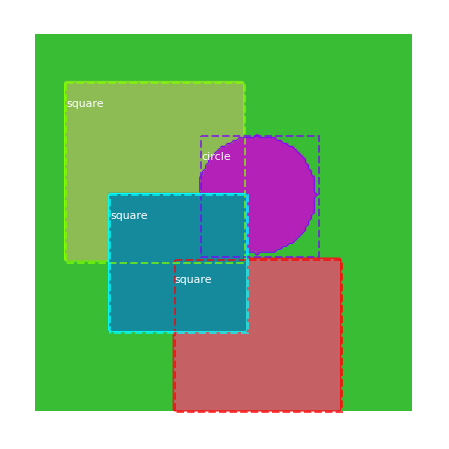

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   21.00000  max:  234.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -95.80000  max:  110.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


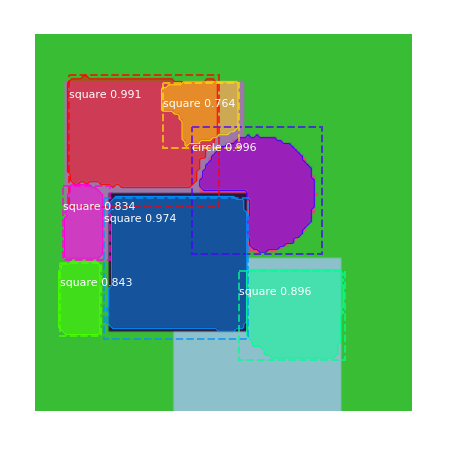

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

our info is:  {'id': 8, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([181,  53,  37]), 'shapes': [('circle', (122, 212, 211), (88, 81, 30))]}
our shapes is:  [('circle', (122, 212, 211), (88, 81, 30))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[2]
(1,)
mask
(128, 128, 1)
our info is:  {'id': 4, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([153, 141, 253]), 'shapes': [('square', (251, 149, 48), (50, 106, 25))]}
our shapes is:  [('square', (251, 149, 48), (50, 106, 25))]
our count is:  1
initial mask shape:  (128, 128, 1)
our class ids: 
[1]
(1,)
mask
(128, 128, 1)
our info is:  {'id': 37, 'source': 'shapes', 'path': None, 'width': 128, 'height': 128, 'bg_color': array([106, 174,  68]), 'shapes': [('square', (238, 16, 136), (61, 20, 29)), ('circle', (107, 138, 230), (31, 69, 26))]}
our shapes is:  [('square', (238, 16, 136), (61, 20, 29)), ('circle', (107, 138, 230), (31, 69, 26))]
our count